In [25]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl

import math
import numpy as np
import pandas as pd
import tensorflow as tf
import socket
import importlib
import os
import sys
#BASE_DIR = os.path.dirname(os.path.abspath(__file__))
#sys.path.append(BASE_DIR)

from pointnetvlad_eval_with_scores import *
from sklearn.neighbors import NearestNeighbors, KDTree

from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef
from sklearn.metrics import auc


In [26]:
QUERY_PATH = 'pointnetvlad_submaps/'

base_results_path = 'testing_results'
results_path = os.path.join(base_results_path,'pointnetvlad')

if not os.path.exists(base_results_path): os.mkdir(base_results_path)
if not os.path.exists(results_path): os.mkdir(results_path)

partial_results_path = os.path.join(results_path,"partial")
successive_results_path = os.path.join(results_path,"successive")

if not os.path.exists(partial_results_path): os.mkdir(partial_results_path)
if not os.path.exists(successive_results_path): os.mkdir(successive_results_path)
    
results_path, partial_results_path, successive_results_path

('testing_results/pointnetvlad',
 'testing_results/pointnetvlad/partial',
 'testing_results/pointnetvlad/successive')

# Step 3.1.1: One-time partial release case: inference using pointnetvlad

In [27]:
pickle_file = '/hololens_partial_results.pickle'

try:
    with open(partial_results_path + pickle_file,'rb') as pickle_output:
        results_pickle = pickle.load(pickle_output)
except:
    print("No pickle file yet:",pickle_file)
    results_pickle = []
    
for radius in np.arange(0.25,3.1,0.25):
    
    query_fol = 'ransac_partial_radius_'+str(radius)+"_4096_unassisted"#
    
    QUERY_FILE = 'pointnetvlad_submaps/3d_{}_evaluation_query.pickle'.format(query_fol)
    
    output_file = RESULTS_FOLDER +pickle_file+query_fol+'.txt'
    
    QUERY_SETS= get_sets_dict(QUERY_FILE)

    query_partial_path = os.path.join(QUERY_PATH,query_fol)

    df_test= pd.read_csv(os.path.join(query_partial_path,"pointcloud_centroids_4m.csv"),sep=',')
    
    QUERY_DATABASE_NUMPY = np.asarray(df_test)
    
    print("Doing",QUERY_FILE,query_partial_path)
    
    ave_recall, ave_intra_dist, test_recall = evaluate(QUERY_SETS, QUERY_DATABASE_NUMPY, output_file)
    
    print(len(test_recall))
    
    results_pickle.append([
            radius,
            ave_recall,
            ave_intra_dist,
            test_recall
    ])

    with open(partial_results_path + pickle_file,'wb') as pickle_output:
        pickle.dump(results_pickle,pickle_output)

    

No pickle file yet: /hololens_partial_results.pickle
Trajectories Loaded.
Doing pointnetvlad_submaps/3d_ransac_partial_radius_0.25_4096_unassisted_evaluation_query.pickle pointnetvlad_submaps/ransac_partial_radius_0.25_4096_unassisted
Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Model restored.
0 1
(990, 256)
0 0 Database output: (27912, 256) Queries output: (990, 256)
1 0 Database output: (27347, 256) Queries output: (990, 256)
 Average Inter-space Error: 0.8545454545454545
 Ave Intra-space Distance Error: 1.3366090406944595
 Average similarity: 0.942467
2
Trajectories Loaded.
Doing pointnetvlad_submaps/3d_ransac_partial_radius_0.5_4096_unassisted_evaluation_query.pickle pointnetvlad_submaps/ransac_partial_radius_0.5_4096_unassisted
Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/

# Step 3.1.2: Results: One-time release case with pointnetVLAD (vs NN-matcher)

In [28]:
pickle_file = '/hololens_partial_results.pickle'

try:
    with open(partial_results_path + pickle_file,'rb') as pickle_output:
        results_pickle = pickle.load(pickle_output)
except:
    print("No results.")
    
pointnetvlad_results = []
pointnetvlad_per_space_score = []
pointnetvlad_perf_scores= []

for radius, recall, intra_dist, test_recall in results_pickle[-12:]:
    
    pointnetvlad_results.append([
        radius,
        recall[0],
        intra_dist[0]
    ])
    
    count_diff = 0

    errors_pool = []
    
    for m, n, top1_obj_cands in test_recall:
        
        """
        if len(errors_pool) == 0:
            errors_pool = top1_obj_cands
        else:
            errors_pool = np.concatenate((errors_pool,top1_obj_cands), axis = 0)
        """
        
        for original_vertex, orig_label, cand_label in top1_obj_cands:
            
            #print(radius, m ,n, original_vertex, orig_label, cand_label)

            per_obj_label = []
            per_obj_label.append(orig_label)
            per_obj_label.append(cand_label)
            per_obj_label.append(original_vertex[0])
            per_obj_label.append(original_vertex[1])
            per_obj_label.append(original_vertex[2])
            errors_pool.append(per_obj_label)
            
        #print("  ",m,n,len(top1_obj_cands),len(errors_pool))
    errors_pool = np.asarray(errors_pool)
        
    macro_score = f1_score(errors_pool[:,0],errors_pool[:,1],average='macro')    
    micro_score = f1_score(errors_pool[:,0],errors_pool[:,1],average='micro')
    mcc = matthews_corrcoef(errors_pool[:,0],errors_pool[:,1])
    ave_prec_score = precision_score(errors_pool[:,0],errors_pool[:,1],average='macro')
    prec_score = precision_score(errors_pool[:,0],errors_pool[:,1],average=None)
    ave_recl_score = recall_score(errors_pool[:,0],errors_pool[:,1],average='macro')
    recl_score = recall_score(errors_pool[:,0],errors_pool[:,1],average=None)
    
    pointnetvlad_per_space_score.append([
        f1_score(errors_pool[:,0],errors_pool[:,1],average=None),
        prec_score,
        recl_score
    ])
    
    pointnetvlad_perf_scores.append([
        radius,
        macro_score,
        micro_score,
        mcc
        #(np.sum(score_map) - np.trace(score_map))/np.sum(score_map)
    ])

    1 - count_diff/len(test_recall)
    
    
pointnetvlad_results = np.asarray(pointnetvlad_results)
pointnetvlad_per_space_score = np.asarray(pointnetvlad_per_space_score)
pointnetvlad_perf_scores = np.asarray(pointnetvlad_perf_scores)

with open(results_path + "/hololens_summary_results.pickle",'wb') as f:
    pickle.dump([pointnetvlad_results, pointnetvlad_per_space_score, pointnetvlad_perf_scores],f)
    

/home/jaybie/.conda/envs/mr-environment/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


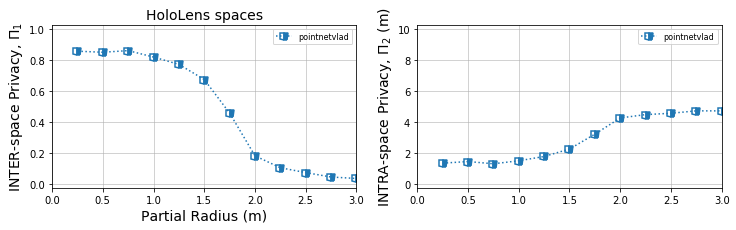

In [30]:
fig=plt.figure(figsize=(12, 3))

with open("testing_results/nn_matcher/hololens_results_partials_nn_matcher.pickle",'rb') as f:
    nn_results_partials, nn_per_space_score, nn_perf_scores = pickle.load(f)

ax1 = fig.add_subplot(121) 

ax1.set_title("HoloLens spaces", fontsize = 14)
ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,3.0)
ax1.set_ylabel("INTER-space Privacy, $\Pi_1$", fontsize = 14)
ax1.set_xlabel("Partial Radius (m)", fontsize = 14)

markersize = 7
linewidth = 1.5

nn_results_partials = np.asarray(nn_results_partials[1])

#"""
ax1.plot(
    nn_results_partials[:,0],
    nn_results_partials[:,1],
    "-o",
    linewidth = linewidth,fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NN-matcher"
)
#"""

ax1.plot(
    pointnetvlad_results[:,0],
    pointnetvlad_results[:,1],
    ":s",
    linewidth = linewidth,fillstyle = 'right',
    mew = linewidth,markersize = markersize,
    label = "pointnetvlad"
)

ax1.legend(loc = "upper right", ncol = 2, fontsize = 8);

ax2 = fig.add_subplot(122) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,10.25)
ax2.set_xlim(0,3)

ax2.set_ylabel("INTRA-space Privacy, $\Pi_2$ (m)", fontsize = 14)
ax1.set_xlabel("Partial Radius (m)", fontsize = 14)

#"""
ax2.plot(
    nn_results_partials[:,0],
    nn_results_partials[:,2],
    "-o",
    linewidth = linewidth,fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NN-matcher"
)
#"""

ax2.plot(
    pointnetvlad_results[:,0],
    pointnetvlad_results[:,2],
    ":s",
    linewidth = linewidth,fillstyle = 'right',
    mew = linewidth,markersize = markersize,
    label = "pointnetvlad"
)

ax2.legend(loc = "upper right", ncol = 1, fontsize = 8);

#plt.savefig('plots/partials-radius-with-pointnetvlad.png', format='png', dpi=300,bbox_inches = 'tight')


# Step 3.2.1: Successive case: spatial inference using pointnetvlad

In [7]:
for radius in np.arange(0.5,2.1,0.5):
    
    pickle_file = '/successive_hololens_results_'+str(radius)+'.pickle'

    try:
        with open(successive_results_path + pickle_file,'rb') as pickle_output:
            results_pickle = pickle.load(pickle_output)
    except:
        print("No "+pickle_file+" file yet.")
        results_pickle = []

    successive_path = 'successive_radius_'+str(radius)
    
    for release in np.arange(1,100,5):

        query_fol = 'release_'+str(release)

        QUERY_FILE = 'pointnetvlad_submaps/successive_queries/3d_jittered_{}_evaluation_query.pickle'.format(successive_path+"_"+query_fol)

        output_file = RESULTS_FOLDER +pickle_file+query_fol+'.txt'

        QUERY_SETS= get_sets_dict(QUERY_FILE)

        query_partial_path = os.path.join(QUERY_PATH,successive_path,query_fol)

        df_test= pd.read_csv(os.path.join(query_partial_path,"pointcloud_centroids_4m.csv"),sep=',')

        QUERY_DATABASE_NUMPY = np.asarray(df_test)

        print("Doing",QUERY_FILE,query_partial_path)

        ave_recall, ave_intra_dist = evaluate(QUERY_SETS, QUERY_DATABASE_NUMPY, output_file)

        results_pickle.append([
                release,
                ave_recall,
                ave_intra_dist
            ])

        with open(successive_results_path + pickle_file,'wb') as pickle_output:
            pickle.dump(results_pickle,pickle_output)
    


No successive_results_0.5_updated_refs.pickle file yet.
Trajectories Loaded.
Doing pointnetvlad_submaps/successive_queries/3d_jittered_successive_radius_0.5_release_1_evaluation_query.pickle pointnetvlad_submaps/successive_radius_0.5/release_1
Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Model restored.
0 1
(226, 256)
0 0 Database output: (27912, 256) Queries output: (226, 256)
1 0 Database output: (27347, 256) Queries output: (226, 256)
 Average Inter-space Error: 0.8451327433628318
 Ave Intra-space Distance Error: 1.5377051941105806
 Average similarity: 0.8069324
Trajectories Loaded.
Doing pointnetvlad_submaps/successive_queries/3d_jittered_successive_radius_0.5_release_6_evaluation_query.pickle pointnetvlad_submaps/successive_radius_0.5/release_6
Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parame

 Average Inter-space Error: 0.28246753246753253
 Ave Intra-space Distance Error: 4.136108852126281
 Average similarity: 0.95171416
Trajectories Loaded.
Doing pointnetvlad_submaps/successive_queries/3d_jittered_successive_radius_0.5_release_66_evaluation_query.pickle pointnetvlad_submaps/successive_radius_0.5/release_66
Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Model restored.
0 1
(181, 256)
0 0 Database output: (27912, 256) Queries output: (181, 256)
1 0 Database output: (27347, 256) Queries output: (181, 256)
 Average Inter-space Error: 0.33977900552486184
 Ave Intra-space Distance Error: 3.553090735106834
 Average similarity: 0.94786817
Trajectories Loaded.
Doing pointnetvlad_submaps/successive_queries/3d_jittered_successive_radius_0.5_release_71_evaluation_query.pickle pointnetvlad_submaps/successive_radius_0.5/release_71
Tensor("query_triplets/Mul_1:0", shape=

1 0 Database output: (27347, 256) Queries output: (161, 256)
 Average Inter-space Error: 0.18322981366459623
 Ave Intra-space Distance Error: 4.495070076717466
 Average similarity: 0.9572227
Trajectories Loaded.
Doing pointnetvlad_submaps/successive_queries/3d_jittered_successive_radius_1.0_release_31_evaluation_query.pickle pointnetvlad_submaps/successive_radius_1.0/release_31
Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Model restored.
0 1
(153, 256)
0 0 Database output: (27912, 256) Queries output: (153, 256)
1 0 Database output: (27347, 256) Queries output: (153, 256)
 Average Inter-space Error: 0.1895424836601307
 Ave Intra-space Distance Error: 4.22473438641625
 Average similarity: 0.9718021
Trajectories Loaded.
Doing pointnetvlad_submaps/successive_queries/3d_jittered_successive_radius_1.0_release_36_evaluation_query.pickle pointnetvlad_submaps/successive_radi

Model restored.
0 1
(153, 256)
0 0 Database output: (27912, 256) Queries output: (153, 256)
1 0 Database output: (27347, 256) Queries output: (153, 256)
 Average Inter-space Error: 0.10784313725490191
 Ave Intra-space Distance Error: 4.496933605238558
 Average similarity: 0.9733954
Trajectories Loaded.
Doing pointnetvlad_submaps/successive_queries/3d_jittered_successive_radius_1.0_release_96_evaluation_query.pickle pointnetvlad_submaps/successive_radius_1.0/release_96
Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Model restored.
0 1
(157, 256)
0 0 Database output: (27912, 256) Queries output: (157, 256)
1 0 Database output: (27347, 256) Queries output: (157, 256)
 Average Inter-space Error: 0.10509554140127386
 Ave Intra-space Distance Error: 4.421935800660928
 Average similarity: 0.9722998
No successive_results_1.5_updated_refs.pickle file yet.
Trajectories Loaded.
D

Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Model restored.
0 1
(152, 256)
0 0 Database output: (27912, 256) Queries output: (152, 256)
1 0 Database output: (27347, 256) Queries output: (152, 256)
 Average Inter-space Error: 0.06907894736842113
 Ave Intra-space Distance Error: 4.64602215157648
 Average similarity: 0.97754455
Trajectories Loaded.
Doing pointnetvlad_submaps/successive_queries/3d_jittered_successive_radius_1.5_release_61_evaluation_query.pickle pointnetvlad_submaps/successive_radius_1.5/release_61
Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Model restored.
0 1
(162, 256)
0 0 Database output: (27912, 256) Queries output: (162, 256)
1 0 Database output: (27347, 256) Queries output: (162, 256)
 Average Inter-space Error: 0.111111111111

Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Model restored.
0 1
(159, 256)
0 0 Database output: (27912, 256) Queries output: (159, 256)
1 0 Database output: (27347, 256) Queries output: (159, 256)
 Average Inter-space Error: 0.11635220125786161
 Ave Intra-space Distance Error: 4.521822321050637
 Average similarity: 0.98038036
Trajectories Loaded.
Doing pointnetvlad_submaps/successive_queries/3d_jittered_successive_radius_2.0_release_26_evaluation_query.pickle pointnetvlad_submaps/successive_radius_2.0/release_26
Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Model restored.
0 1
(156, 256)
0 0 Database output: (27912, 256) Queries output: (156, 256)
1 0 Database output: (27347, 256) Queries output: (156, 256)
 Average Inter-space Error: 0.10576923076

Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Model restored.
0 1
(163, 256)
0 0 Database output: (27912, 256) Queries output: (163, 256)
1 0 Database output: (27347, 256) Queries output: (163, 256)
 Average Inter-space Error: 0.08895705521472397
 Ave Intra-space Distance Error: 4.866344761725418
 Average similarity: 0.97869444
Trajectories Loaded.
Doing pointnetvlad_submaps/successive_queries/3d_jittered_successive_radius_2.0_release_91_evaluation_query.pickle pointnetvlad_submaps/successive_radius_2.0/release_91
Tensor("query_triplets/Mul_1:0", shape=(51, 256), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from model/model_3d_4m_jittered_4096.ckpt
Model restored.
0 1
(159, 256)
0 0 Database output: (27912, 256) Queries output: (159, 256)
1 0 Database output: (27347, 256) Queries output: (159, 256)
 Average Inter-space Error: 0.04088050314

# Step 3.2.2: Results: Successive case with pointnetVLAD (vs NN-matcher)

In [8]:
pointnetvlad_successive = []

for radius in np.arange(0.5,2.1,0.5):
    
    pickle_file = '/successive_hololens_results_'+str(radius)+'.pickle'

    pointnetvlad_successive_per_radius = []

    try:
        with open(successive_results_path + pickle_file,'rb') as pickle_output:
            results_pickle = pickle.load(pickle_output)
    except:
        print("No results_ransac.")

    for release, recall, intra_dist in results_pickle:
        pointnetvlad_successive_per_radius.append([
            release,
            recall[0],
            intra_dist[0]
        ])

    pointnetvlad_successive_per_radius = np.asarray(pointnetvlad_successive_per_radius)#[-16:]

    pointnetvlad_successive.append(pointnetvlad_successive_per_radius)
    
with open('testing_results/nn_matcher/successive/nn_matcher_errors.pickle', 'rb') as f:
    [succ_NN_errors, succ_NN_intra_errors] = pickle.load(f)

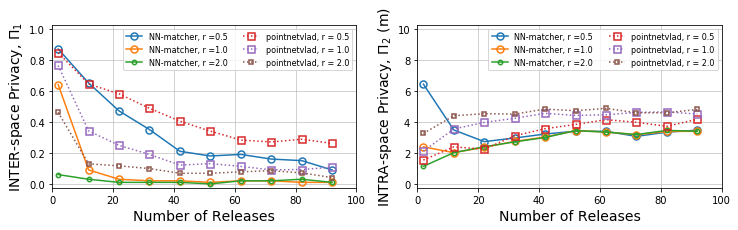

In [9]:
fig=plt.figure(figsize=(12, 3))

ax1 = fig.add_subplot(121) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,100)
ax1.set_ylabel("INTER-space Privacy, $\Pi_1$", fontsize = 14)
ax1.set_xlabel("Number of Releases", fontsize = 14)

markersize = 7
linewidth = 1.5
#plt.minorticks_on()

for radius, inter_errors in succ_NN_errors:#[:2]:

    if radius == 1.5: continue

    #print(RawNN_per_iteration_errors.shape)
    ax1.plot(
        np.arange(1,100,10)[:len(inter_errors):]+1,
        inter_errors[::], 
        '-o', 
        linewidth = linewidth,fillstyle = 'none',
        mew = linewidth,markersize = min(markersize*(1.25/radius),markersize),
        label = "NN-matcher, r ="+ str(radius)
    )

for i, radius in enumerate(np.arange(0.5,2.1,0.5)):

    if radius == 1.5: continue

    ax1.plot(
        np.arange(1,100,10)+1,
        pointnetvlad_successive[i][::2,1],
        ":s",
        linewidth = linewidth,fillstyle = 'none',
        mew = linewidth,markersize = min(markersize*(1.25/radius),markersize),
        label = "pointnetvlad, r = "+str(radius)
    )

ax1.legend(loc = "upper right", ncol = 2, fontsize = 8);

ax2 = fig.add_subplot(122) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,10.25)
ax2.set_xlim(0,100)

ax2.set_ylabel("INTRA-space Privacy, $\Pi_2$ (m)", fontsize = 14)
ax2.set_xlabel("Number of Releases", fontsize = 14)

for radius, intra_errors in succ_NN_intra_errors:#[:2]:
    
    if radius == 1.5: continue
    
    ax2.plot(
        np.arange(1,100,10)+1,#[:len(intra_errors):2]+1,
        intra_errors[::,0], 
        '-o',
        linewidth = linewidth, #capsize = 4.0, 
        #marker = markers[0],
        fillstyle = 'none',
        mew = linewidth,markersize = min(markersize*(1.25/radius),markersize),
        label = "NN-matcher, r ="+ str(radius)
    )

for i, radius in enumerate(np.arange(0.5,2.1,0.5)):

    if radius == 1.5: continue

    ax2.plot(
        np.arange(1,100,10)+1,
        pointnetvlad_successive[i][::2,2],
        ":s",
        linewidth = linewidth,fillstyle = 'none',
        mew = linewidth,markersize = min(markersize*(1.25/radius),markersize),
        label = "pointnetvlad, r = "+str(radius)
    )


ax2.legend(loc = "upper right", ncol = 2, fontsize = 8);

plt.savefig('plots/successive-with-pointnetvlad.png', format='png', dpi=300,bbox_inches = 'tight')
